In [1]:
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline
import platform
from scipy.optimize import curve_fit
from mpl_toolkits.mplot3d import Axes3D
from skimage import morphology, feature, transform, filters

In [55]:
try:
    from shapes import *
    from detect_bubbles import *
    from utils import *
except ImportError:
    pass

In [56]:
from classify_bubble import *
from bubbleNet1D import *

/Users/Habib/anaconda/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [57]:
%load_ext autoreload
%autoreload 2

In [2]:
def show_bubble_circle(image, circ, color="red"):
    fig1 = plt.figure(figsize=(8,8))
    ax1 = fig1.add_subplot(111, aspect='equal')
    plt.imshow(image, cmap="gray")
    ax1.add_patch(
                patches.Circle(
                    (circ.y, circ.x),   
                    circ.radius,
                    fill=False,
                    color=color))

In [3]:
plat = platform.system()
if plat == "Darwin":
    calib_dir =  "/Users/Habib/Google Drive/Uni Heidelberg/11 WS 2017-2018/Masterarbeit/Messungen/Reihe_32_calib_radius" 
elif plat == "Windows":
    calib_dir = "../Messungen/Reihe_32_calib_radius/"

In [4]:
cim = []
bgim = []
filenames = []
for file in os.listdir(calib_dir):
    filenames.append(file)

filenames.sort() # sort after creation date since date is in the name

In [5]:
cim = []
bgim = []
for file in filenames[1:]:
    if file.endswith(".bmp"):
        if int(file[-5:-4])%2 ==0:
            img = cv2.imread(os.path.join(calib_dir, file), 0)
            cim.append(img)
        else:
            img = cv2.imread(os.path.join(calib_dir, file), 0)
            bgim.append(img)

## The algorithm -> Radius calibration -> green radius

In [20]:
green_bubble =  bgim[0][75:135, 675:730]

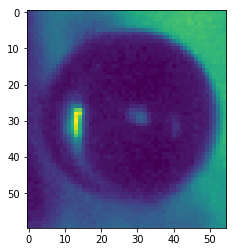

In [21]:
plt.imshow(green_bubble)

In [24]:
edges = filters.sobel(green_bubble)

In [77]:
edges_profile = np.loadtxt("../thesis/extern/edges_profile.csv", skiprows=1, delimiter=",")

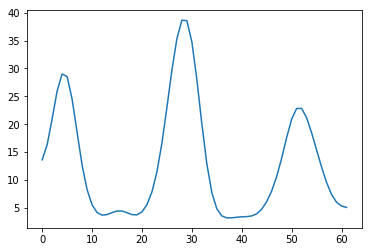

In [78]:
from scipy.ndimage.filters import gaussian_filter1d
ydata = gaussian_filter1d(edges_profile.T[1], sigma=2)
plt.plot(ydata)

In [59]:
xdata = np.arange(0, len(ydata))

In [85]:
def gauss(x, a, mu, sigma):
    return a * np.exp(- (x - mu)**2/sigma**2)

In [86]:
popt1, _ = curve_fit(gauss, xdata, ydata, p0=[30, 5, 2])
popt2, _ = curve_fit(gauss, xdata, ydata, p0=[30, 56, 2])

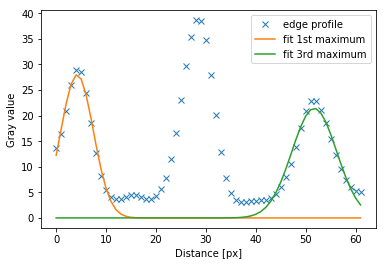

In [90]:
plt.plot(ydata, 'x', label="edge profile")
plt.plot(xdata, gauss(xdata, *popt1), label="fit 1st maximum")
plt.plot(xdata, gauss(xdata, *popt2), label="fit 3rd maximum")
plt.xlabel("Distance [px]")
plt.ylabel("Gray value")
plt.legend()
plt.savefig("../thesis/graphs/green_radius_demo.png")

# The algorithm -> radius calibration -> factor

In [136]:
# data from radius_calibration.ipynb

red_radii = []
green_radii = []

red_radii.append( [15.5, 15, 16, 16, 15.5, 16])
green_radii.append( [19.35, 20.05, 20.02, 20.09])

red_radii.append( [7, 7.5, 6, 7.5, 7.5, 7, 7.5, 6.5] )
green_radii.append( [12.09, 11.22, 12.07, 11.02])

red_radii.append([11.5, 11, 11.5])
green_radii.append( [14.07, 14.87, 15] )

red_radii.append([9, 9.5, 9.5, 9, 9.5, 10])
green_radii.append([13.06, 13.93, 14.01] )



In [137]:
x_data = [np.mean(r) for r in red_radii]
y_data = [np.mean(g) for g in green_radii]
y_err = [np.std(r) for r in red_radii]
x_err = [np.std(g) for g in green_radii]

In [139]:
def lin(x, a, b):
    return a*x +b

In [140]:
popt_lin, _ = curve_fit(lin, x_data, y_data)

In [147]:
popt_lin

array([0.95690246, 4.54637797])

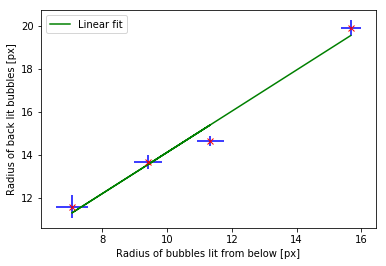

In [150]:
plt.errorbar(x_data, y_data, xerr=x_err, yerr=y_err, fmt='rx', ecolor='b', label="")
plt.plot(x_data, lin(np.asarray(x_data), *popt_lin), 'g', label="Linear fit")
plt.xlabel("Radius of bubbles lit from below [px]")
plt.ylabel("Radius of back lit bubbles [px]")
plt.legend()
plt.savefig("../thesis/graphs/radius_calibration_result.png")